In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import torch
import nibabel
import data.constants as constants
import nilearn.masking as masking
import numpy as np
import pandas as pd
from data import ward_tree

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
chkfn = '/data/brain_/gcn/outputs/clf/fc/wn/models/model_epoch99.checkpoint'
chk = torch.load(chkfn, map_location='cpu')
try:
    del wg
except:
    pass
try:
    del wv
except:
    pass    
wg = chk['model']['net.0.weight_g'].cpu().numpy()
wv = chk['model']['net.0.weight_v'].cpu().numpy()

In [4]:
wtree = constants.get_wtree()
adj_list = []
cur_level = wtree.get_leaves()
z_size = 128
in_features = 212445
node_sizes = [in_features, z_size * 512, z_size * 128, z_size]
parcellations = []
for next_count in [8, 128, 512]:
    parcellations.append(wtree.cut(next_count))

for next_count in node_sizes[1:]:
    cur_level, _, adj = wtree.get_level_and_adjacency(next_count, cur_level)
    # cur_level, _, adj = ward_tree.go_up_to_reduce(cur_level, next_count)
    adj_list.append(adj)

212445
True
65536
True
16384
False


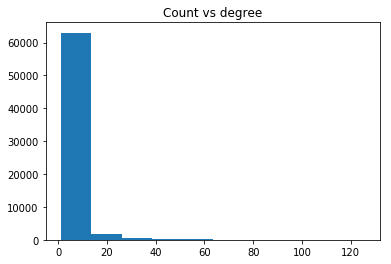

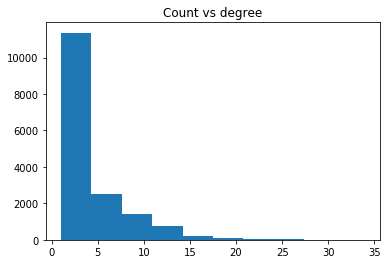

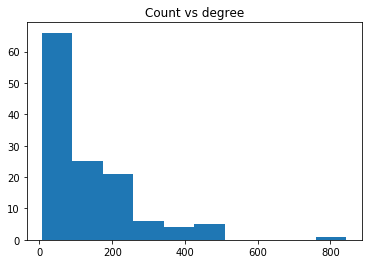

In [5]:
for adj in adj_list:
    plt.figure()
    degrees = [len(x) for x in adj]
    print(sum(degrees))
    print(any(x == 1 for x in degrees))
    plt.hist(degrees)
    plt.title("Count vs degree")

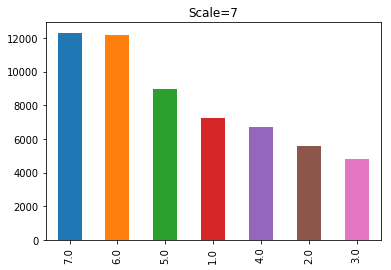

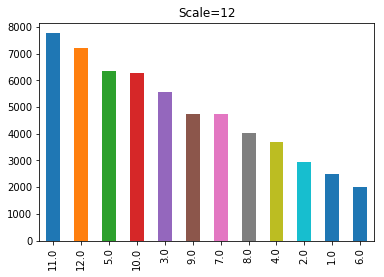

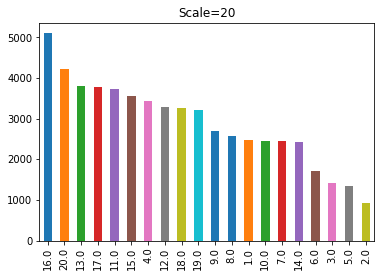

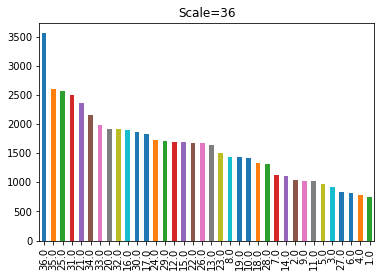

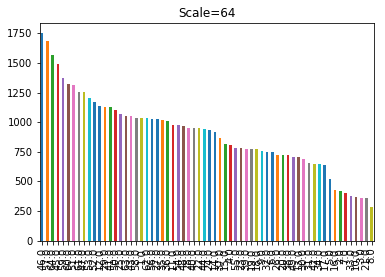

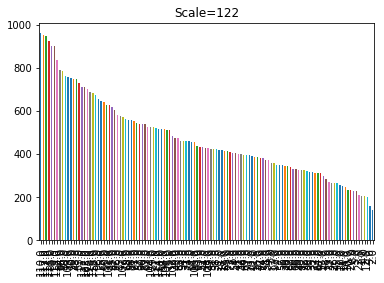

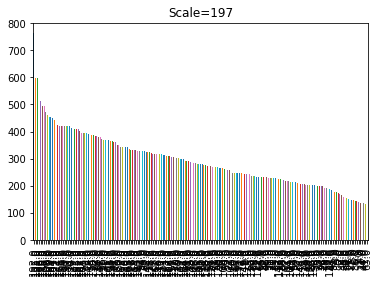

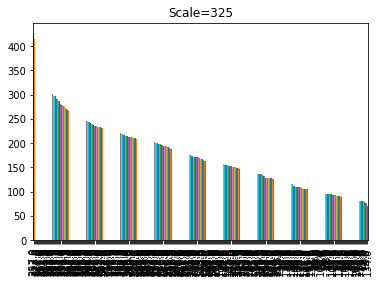

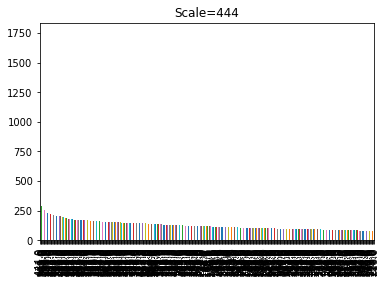

In [16]:
for scale in constants.basc_scales:
    arr = constants.basc_images[scale].get_data()
    plt.figure()
    pd.DataFrame(arr[arr > 0])[0].value_counts().plot(kind='bar')
    plt.title("Scale={}".format(scale))

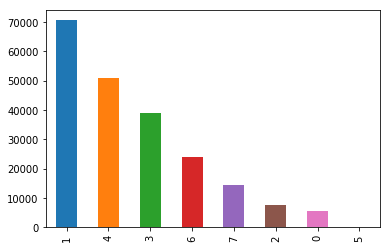

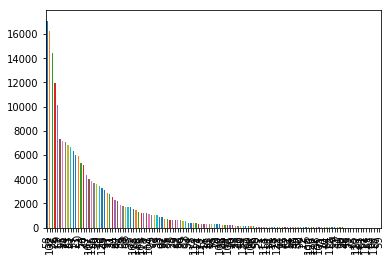

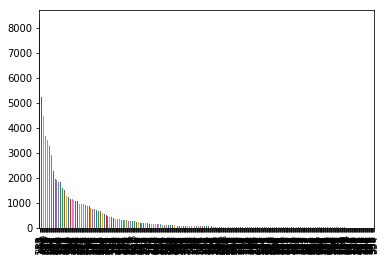

In [7]:
for parcels in parcellations:
    df = pd.DataFrame(parcels)
    plt.figure()
    df[0].value_counts().plot(kind='bar')

# BELOW THIS LIES OLD WARD_TREE CODE

In [3]:
parcels = nibabel.load(constants.ward_parcellation_image)
wtree = constants.get_wtree()
nregions = 128
_ = wtree.make_val2region(nregions)
masked_parcels = masking.apply_mask(parcels, constants.original_brain_mask)
masked_parcels_df = pd.DataFrame(data=masked_parcels.astype(np.int), index=list(range(len(masked_parcels))))

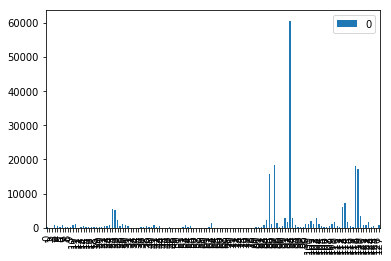

In [9]:
nregions = 128
_ = wtree.make_val2region(nregions)
regions = np.array([wtree.val2region[i] for i in range(len(masked_parcels))])
nareas = {i: (regions == i).sum() for i in range(nregions)}
pd.DataFrame.from_dict(nareas, orient='index').plot.bar()

In [5]:
z_size = 128
node_sizes = [len(regions), z_size * 1024, z_size * 128, z_size]
adj_list = []
cur_level = wtree.get_leaves()
for next_count in node_sizes[1:]:
    cur_level, _, adj = ward_tree.go_up_to_reduce(cur_level, next_count)
    adj_list.append(adj)

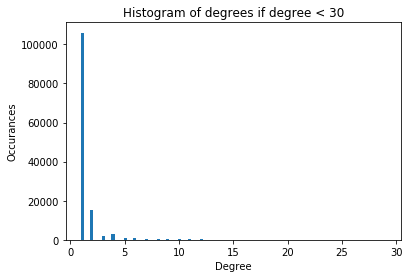

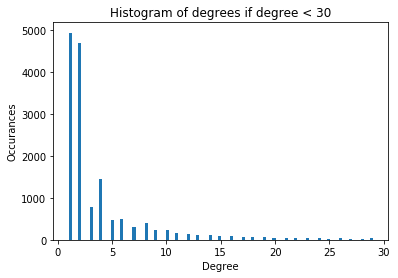

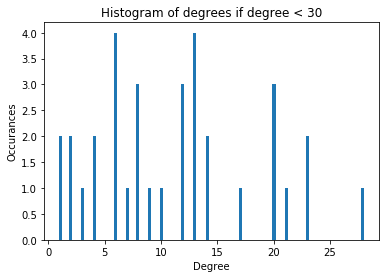

In [21]:
d_list = []
for adj in adj_list:
    degrees = [len(row) for row in adj]
    d_list.append(degrees)
    plt.figure()
    plt.hist([d for d in degrees if d < 30], bins=100)
    plt.title("Histogram of degrees if degree < 30")
    plt.xlabel("Degree")
    plt.ylabel("Occurances")

(array([21722., 15723., 35840., 14823., 38269., 17449., 16630., 17347.,
        25582.,  9060.]),
 array([  1. ,  13.7,  26.4,  39.1,  51.8,  64.5,  77.2,  89.9, 102.6,
        115.3, 128. ]),
 <a list of 10 Patch objects>)

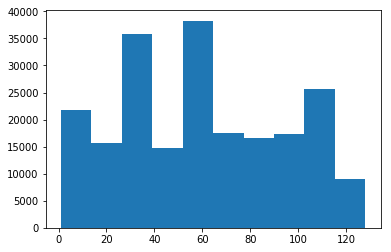

In [14]:
plt.hist(masked_parcels_df[0].tolist())

(array([ 4686.,  9382., 10847.,  1641.,  3034.,   183., 40337., 74288.,
        22768., 45279.]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <a list of 10 Patch objects>)

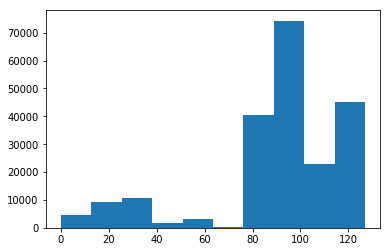

In [17]:
plt.hist(regions)

(array([122.,   1.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 6.0640e+03, 1.2127e+04, 1.8190e+04, 2.4253e+04,
        3.0316e+04, 3.6379e+04, 4.2442e+04, 4.8505e+04, 5.4568e+04,
        6.0631e+04]),
 <a list of 10 Patch objects>)

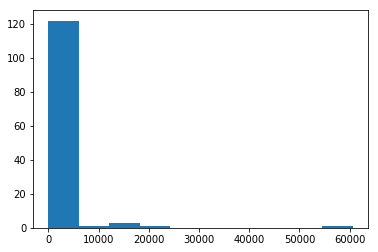

In [16]:
plt.hist([nareas[i] for i in range(128)])

In [35]:
min([wtree.nodes[i].depth for i in range(len(masked_parcels_df[0]))])

7

In [37]:
lvl128 = wtree.first_level_of_size(128)

In [41]:
min([node.depth for node in lvl128])

7